In [1]:
#ignoring warnings
import warnings
warnings.simplefilter('ignore')

#importing neccesary modules
import sys
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
from dateutil.parser import parse
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import time
from datetime import datetime, timezone
from dateutil import parser
import oandapyV20.endpoints.instruments as instruments
import configparser
import json
from oandapyV20 import API
import oandapyV20.endpoints.positions as positions
import oandapyV20.endpoints.trades as trades
from oandapyV20.endpoints.pricing import PricingStream
import oandapyV20.endpoints.orders as orders
import oandapyV20.endpoints.accounts as accounts
from oandapyV20.contrib.factories import InstrumentsCandlesFactory
from oandapyV20.contrib.requests import MarketOrderRequest, TrailingStopLossDetails
from oandapyV20.exceptions import V20Error, StreamTerminated
import sqlite3
from collections import OrderedDict, ChainMap
from statsmodels.tsa.stattools import coint, grangercausalitytests

In [2]:
#https://oanda-api-v20.readthedocs.io/en/latest/index.html
config = configparser.ConfigParser()
config.read('oanda_new.cfg')

client = API(access_token=config['oanda']['access_token'])

In [3]:
def get_data(_from, _to, granularity, instrument, save_csv=False):
    """
        Collect historical data for training
        _from="2018-15-15 00:00"    date and time to start collecting candles
        _to=""                      date and time to end the collection of candles, if "", then end will be now.
        save_csv if True will save csv file in current folder
    """
    if _to == "":
        _to = datetime.strptime(datetime.now().isoformat()[0:19] + "Z", '%Y-%m-%dT%H:%M:%SZ').strftime('%Y-%m-%dT%H:%M:%SZ')
    else:
        _to = datetime.strptime(parser.parse(_to).isoformat() + "Z", '%Y-%m-%dT%H:%M:%SZ').strftime('%Y-%m-%dT%H:%M:%SZ')
    params = {
    "granularity": granularity,
    "from": datetime.strptime(parser.parse(_from).isoformat() + "Z", '%Y-%m-%dT%H:%M:%SZ').strftime('%Y-%m-%dT%H:%M:%SZ'),
    "to": _to
    }
    
    df = pd.DataFrame(columns=["Date", 'Open', 'High', 'Low', 'Close', "Volume"])
    for r in InstrumentsCandlesFactory(instrument=instrument, params=params):
        rv = client.request(r)

        results = [{"Date":candle['time'][0:19], "Open":float(candle['mid']['o']),
                    "High":float(candle['mid']['h']), "Low":float(candle['mid']['l']),
                   "Close":float(candle['mid']['c']), "Volume": float(candle['volume'])
                   } for candle in r.response.get('candles')]
        df = df.append(pd.DataFrame(results), ignore_index=True)
    
    df.set_index("Date", inplace=True)
    if save_csv:
        df.to_csv(instrument + "_" + granularity + ".csv")
    return df

In [4]:
start = "2020-01-01 00:00"    #date and time to start collecting candles
end = "2021-10-03 00:00"    #date and time to end the collection of candles, if "", then end will be now.
granularity = "D"
instrument = "SG30_SGD"


df1 = get_data(_from=start, _to=end, granularity=granularity, instrument=instrument, save_csv=False)
date_ori = pd.to_datetime(df1.iloc[:, 0]).tolist() 


In [5]:
df1.rename(columns={'Close':'Closedf1'}, inplace=True)

In [6]:
start = "2020-01-01 00:00"    #date and time to start collecting candles
end = "2021-10-03 00:00"    #date and time to end the collection of candles, if "", then end will be now.
granularity = "D"
instrument = "TWIX_USD"

df2 = get_data(_from=start, _to=end, granularity=granularity, instrument=instrument, save_csv=False)
date_ori = pd.to_datetime(df2.iloc[:, 0]).tolist() 
df2.tail()
df2.rename(columns={'Close':'Closedf2'}, inplace=True)

In [7]:
start = "2020-01-01 00:00"    #date and time to start collecting candles
end = "2021-10-03 00:00"    #date and time to end the collection of candles, if "", then end will be now.
granularity = "D"
instrument = "HK33_HKD"

df5 = get_data(_from=start, _to=end, granularity=granularity, instrument=instrument, save_csv=False)
date_ori = pd.to_datetime(df5.iloc[:, 0]).tolist() 
df5.tail()
df5.rename(columns={'Close':'Closedf5'}, inplace=True)

In [8]:
start = "2020-01-01 00:00"    #date and time to start collecting candles
end = "2021-10-03 00:00"    #date and time to end the collection of candles, if "", then end will be now.
granularity = "D"
instrument = "CN50_USD"

df6 = get_data(_from=start, _to=end, granularity=granularity, instrument=instrument, save_csv=False)
date_ori = pd.to_datetime(df6.iloc[:, 0]).tolist() 
df6.tail()
df6.rename(columns={'Close':'Closedf6'}, inplace=True)

In [9]:
df_concat = pd.concat([df1.iloc[:, 3:4], df2.iloc[:, 3:4], df5.iloc[:, 3:4], df6.iloc[:, 3:4] ], axis=1)

In [10]:
df_concat = df_concat.fillna(method='ffill')
df_concat = df_concat.fillna(df_concat.mean())
df_concat.head()

,Closedf1,Closedf2,Closedf5,Closedf6
Date,,,,
2020-01-01T22:00:00,376.88,468.2,28749.9,14628.4
2020-01-02T22:00:00,372.82,461.2,28370.1,14448.2
2020-01-05T22:00:00,372.04,457.7,28262.0,14396.0
2020-01-06T22:00:00,374.55,456.7,28269.0,14416.4
2020-01-07T22:00:00,377.40,457.8,28374.5,14468.8


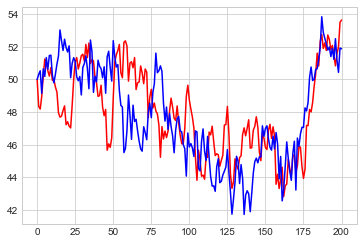

In [11]:
def make_coint_0(N,T0=[0,0],sigma=[1,1],c=[0.1,0.1]):
    '''
    Algorithm from:
    https://www.researchgate.net/publication/254330798_A_Drunk_and_Her_Dog_An_Illustration_of_Cointegration_and_Error_Correction
    '''
    X = [0]
    Y = [0]
    for i in range(N):
        rx = np.random.randn()*sigma[0] - c[0]*(X[-1] - Y[-1])
        ry = np.random.randn()*sigma[1] + c[1]*(X[-1] - Y[-1])
        X.append(X[-1]+rx)
        Y.append(Y[-1]+ry)
    return np.array(X)+T0[0],np.array(Y)+T0[1]

X,Y = make_coint_0(200,T0=[50,50],c=[0.1,0.1])
plt.plot(X,'r-',Y,'b-');

In [12]:
coint(X,Y)

(-4.342652746923805,
 0.0021949667758576724,
 array([-3.95203768, -3.36685108, -3.065724  ]))

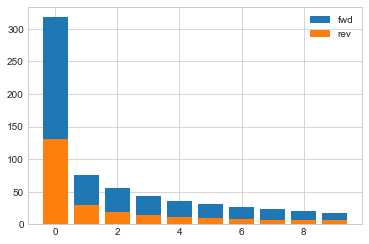

In [13]:
X,Y = make_coint_0(200,T0=[50,50],c=[0.8,0.6])

lags = 10

# Calculating the EG-Test in one direction
result = grangercausalitytests(np.array([X,Y]).T, lags, verbose=False)

# Extracting results
res_fwd = [(list(result.values())[lag][0]['ssr_ftest'][0]) for lag in range(lags)]

# Calculating the EG-Test in reverse direction
result = grangercausalitytests(np.array([Y,X]).T, lags, verbose=False)

# Extracting results
res_rev = [(list(result.values())[lag][0]['ssr_ftest'][0]) for lag in range(lags)]

plt.bar(range(lags),res_fwd,label='fwd')
plt.bar(range(lags),res_rev,label='rev')
plt.legend()

In [14]:
coints = []
for i in range(df_concat.values.shape[1]):
    for k in range(i,df_concat.values.shape[1]):
        if not i==k:
            coints.append(coint(df_concat.values.T[i],df_concat.values.T[k])[0])

            print(i,k,coints[-1])

0 1 -2.924600636338942
0 2 -1.2291273469795396
0 3 -2.1960984726340387
1 2 -1.1793254875600117
1 3 -1.012726289858636
2 3 -2.7582565410617366


<AxesSubplot:xlabel='Date'>

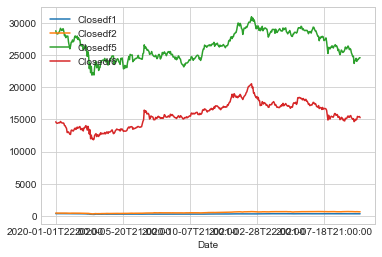

In [15]:
df_concat.plot()

In [16]:
from sklearn.decomposition import PCA

In [17]:
def get_resids(d):
  pca = PCA(1).fit(d.T)
  index=pca.components_[0]
  mm = [sm.OLS(s, index).fit() for s in d.T]
  return list(map(lambda x: x.resid, mm))

def Zscore(X):
    return np.array((X - np.mean(X)) / np.std(X))

In [24]:
th = 0.6
zlist = []

import statsmodels.api as sm

pr = np.array(df_concat).T
max_pos=1
initial_cash=1e6

entry = {} # create a vector of entry prices
pnls = [] # create a pnl vector

# Exit if we specified too large long/short position size
if max_pos > pr.shape[0]/2:
    print('max_pos too large!')
    adfadsf

# loop through the prices
for i,pri in enumerate(pr.T):

    # Make sure you have enough data points for PCA
    if i < 50: continue

    # Run the PCA, only on the past prices
    resids = get_resids(pr.T[max([0,i-60]):i])
    zs = {}

    # Calculate the z-scores for each instrument. 
    for inst in range(len(pri)):
        try: zs[inst] = Zscore(resids[inst])[-1]
        except: 
          print(traceback.format_exc())
        
        zlist.append(zs[inst])

    pnl = 0
    # Calculate the Pnl for each position over the prevoius period
    for j,idx in enumerate(entry):

        # Calculate the position size
        # The sign of the position depends on the sign of the entry price
        pos = np.round((initial_cash/len(pri))/entry[idx])

        # Add up the pnls for all positions for the last period
        # We neutralize the sign of the entry price and let it 
        # come in through the position.
        pnl += (pri[idx]-np.abs(entry[idx]))*pos
        
    pnls.append(pnl)

    # Reset the portfolio
    entry = {}

    # Find the new instruments to be traded based on their z-scores
    idx_long = (np.argsort([zs[j] for j in zs])[:max_pos])
    idx_short = (np.argsort([zs[j] for j in zs])[-max_pos:])

    # Add them to the entry list
    # The entry gets a positive or negative sign depending on the side of the trade
    if (zs[inst]) > th: 
    
        for idx in idx_long:
            entry[idx] = pri[idx]
        for idx in idx_short:
            entry[idx] = -pri[idx]
            
    elif (zs[inst]) < -th: 
    
        for idx in idx_long:
            entry[idx] = pri[idx]
        for idx in idx_short:
            entry[idx] = -pri[idx]            

    #print(i,sum(pnls))
    #print(i,sum(pnls))

In [25]:
print(idx_long)

[2]


In [26]:
print(idx_short)

[3]


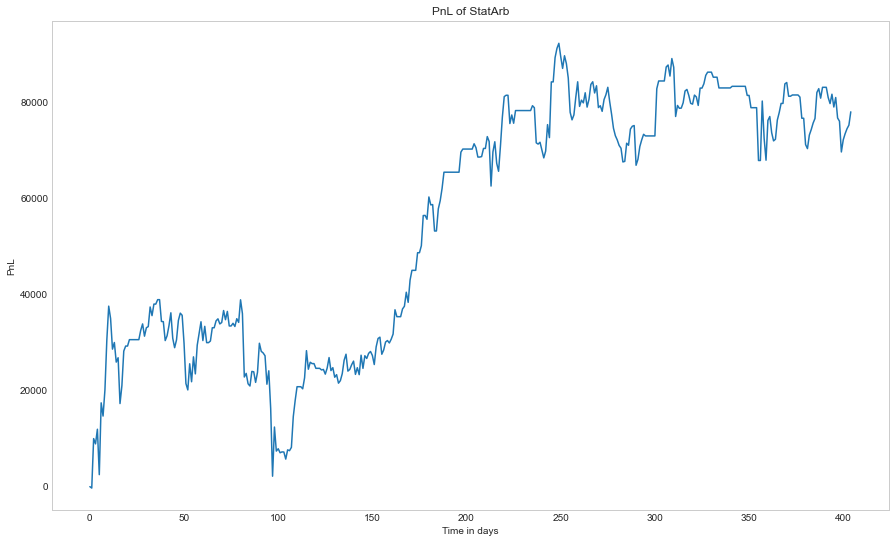

In [27]:
plt.figure(figsize=[15,9])
plt.plot(np.cumsum(pnls))
plt.title('PnL of StatArb')
plt.xlabel('Time in days')
plt.ylabel('PnL')
plt.grid()

In [28]:
print(zs[inst])

2.053928744986788


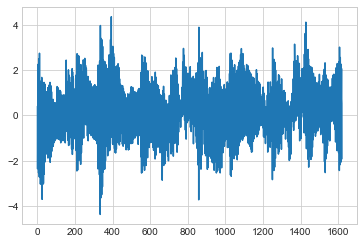

In [29]:
plt.plot(zlist)
plt.show()